In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_parquet(r"./data/processedData_first.parquet")

In [3]:
df = data[['systolic','diastolic','hdl','ldl','bmi','age','diabetic']]

In [4]:
data.head(2)

,patientid,dateofobservation,systolic,diastolic,hdl,ldl,bmi,age,start,diabetic
0,02314aa6-55ab-e606-7089-e3185adee368,2015-02-18T14:33:45Z,145.0,111.0,66.1,84.5,29.2,31.221918,2015-02-18,1
1,032391df-fed2-6b2d-f882-d0328ef23cbe,2013-03-22T18:42:57Z,111.0,84.0,71.1,83.0,29.3,31.221918,None,0


In [5]:
df.head(2)

,systolic,diastolic,hdl,ldl,bmi,age,diabetic
0,145.0,111.0,66.1,84.5,29.2,31.221918,1
1,111.0,84.0,71.1,83.0,29.3,31.221918,0


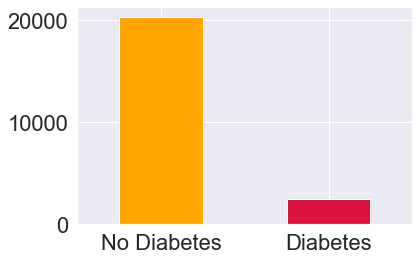

In [45]:
df["diabetic"].value_counts().plot(kind="bar",color=["orange","crimson"])
plt.xticks(np.arange(2), ('No Diabetes', 'Diabetes'),rotation=0);

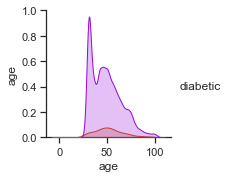

In [46]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,hue='diabetic',palette='gnuplot');

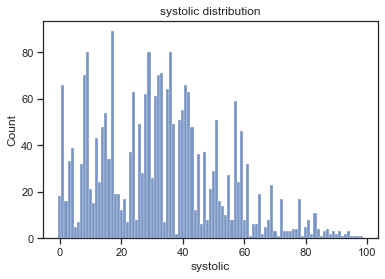

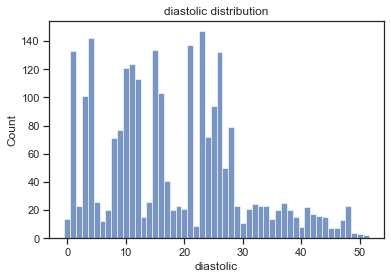

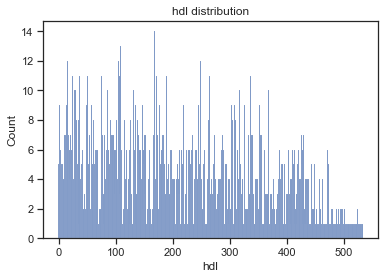

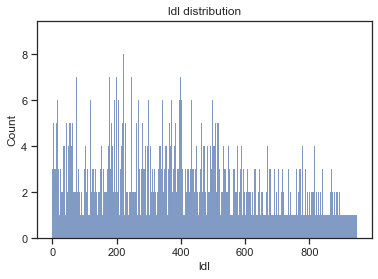

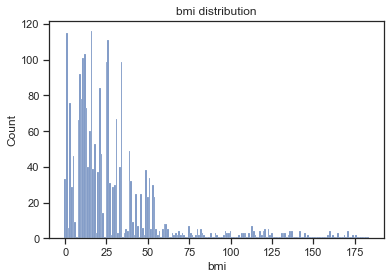

In [47]:
for i,col in enumerate(['systolic','diastolic','hdl','ldl','bmi']):
    plt.figure(i)
    sns.histplot(data=df[df['diabetic']==1],x=col).set(xscale="linear",title="{} distribution".format(col))

In [6]:
from sklearn.model_selection import train_test_split
df.sample(frac=1)


X = df.drop("diabetic",axis=1)
y = df["diabetic"]
X_train,X_test,y_train,y_test =  train_test_split(X,
                                              y,
                                              test_size=0.2)

In [9]:
(len(X_train),len(X_test))

(18188, 4548)

In [10]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train)
log_reg.score(X_test,y_test)

0.9311785400175902

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train);
knn.score(X_test,y_test)

0.9423922603342129

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf= RandomForestClassifier()
clf.fit(X_train,y_train);
clf.score(X_test,y_test)

0.9481090589270009

In [13]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.9397537379067722

In [19]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)
gs_clf = GridSearchCV(rfc,
                          param_grid=param_grid,
                          cv=5,
                          n_jobs=3,
                          verbose=True)

#fit grid search cv
gs_clf.fit(X_train,y_train)
gs_clf.score(X_test,y_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  9.5min finished


0.9478891820580475

In [20]:
clf_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

np.random.seed(42)

rs_clf = RandomizedSearchCV(rfc,
                                param_distributions=param_grid,
                                cv=5,
                                n_iter=20,
                                n_jobs=3,
                                verbose=True)


rs_clf.fit(X_train, y_train)
rs_clf.score(X_test,y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.7min finished


0.9476693051890941

In [21]:
y_preds = gs_clf.predict(X_test)
y_preds

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
np.array(y_test)

array([0, 0, 0, ..., 0, 0, 0])

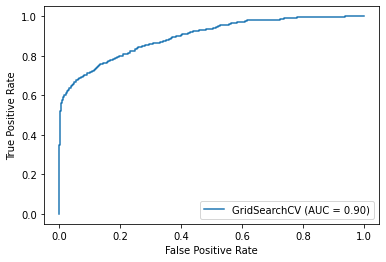

In [25]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(gs_clf,X_test,y_test)

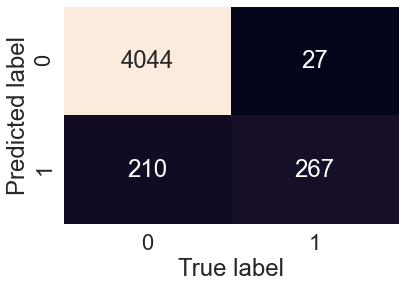

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(y_test,y_preds), annot=True,cbar=False, fmt='g')
plt.xlabel("True label")
plt.ylabel("Predicted label");

In [28]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4071
           1       0.91      0.56      0.69       477

    accuracy                           0.95      4548
   macro avg       0.93      0.78      0.83      4548
weighted avg       0.95      0.95      0.94      4548



In [29]:
import pickle

# Save trained model to file
pickle.dump(gs_clf, open("diabetes0712.pkl", "wb"))

In [30]:
model = pickle.load(open("diabetes0712.pkl", "rb"))

In [44]:
df[df['diabetic']==1].head(5)

,systolic,diastolic,hdl,ldl,bmi,age,diabetic
0,145.0,111.0,66.1,84.5,29.2,31.221918,1
12,113.0,83.0,69.4,88.3,30.2,85.476712,1
25,156.0,102.0,45.0,130.1,25.6,23.205479,1
29,104.0,84.0,52.3,117.9,27.4,68.427397,1
41,105.0,80.0,69.7,100.5,28.6,91.153425,1


In [38]:
row_df = pd.DataFrame([pd.Series([113,82,61.9,102.6,27.3,90])])

In [48]:
model.predict_proba(row_df)[0][1]

0.05703446498273414